# Set up

In [1]:
!pip install git+https://github.com/ficusss/PyGMNormalize.git
!pip install -U scikit-fuzzy
!pip install numba
!pip install umap-learn

  Cloning https://github.com/ficusss/PyGMNormalize.git to /tmp/pip-req-build-jrwx2024
  Running command git clone -q https://github.com/ficusss/PyGMNormalize.git /tmp/pip-req-build-jrwx2024
  Created wheel for pygmnormalize: filename=pygmnormalize-0.2-cp36-none-any.whl size=4669 sha256=9f9d3f06a8a6362f8a150dcce3256e0d83c10412c700af7b8f2fd200a8f81c15
  Stored in directory: /tmp/pip-ephem-wheel-cache-lux36dng/wheels/22/f9/56/db07076bd0b3b986414f211fac814066ed164011fbf3596e2e
Successfully built pygmnormalize
     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=49d4a48913669201a8c20d3576047db5566c06e48b07f3482420045668bacc37
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cluster import KMeans
import seaborn as sb
from skfuzzy.cluster import cmeans, cmeans_predict
import umap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Upload files to colab first
test_data = pd.read_csv('test_data_processed.csv')
train_data = pd.read_csv('train_data_processed.csv')
test_lbl = pd.DataFrame(np.load('test_labels.csv.npy', allow_pickle = True))
train_lbl = pd.DataFrame(np.load('train_labels.csv.npy', allow_pickle = True))

In [0]:
train_data_lbl = pd.concat([train_data, train_lbl], axis = 1)
test_data_lbl = pd.concat([test_data, test_lbl], axis = 1)

train_data_lbl.columns.values[-1] = 'Grade'
test_data_lbl.columns.values[-1] = 'Grade'

In [0]:
def get_accuracy(true_labels, predicted_labels):
    accuracy = 0
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            accuracy += 1
    return accuracy/len(true_labels)

# Unsupervised UMAP

## Implement

In [0]:
i = 2
UMAP = umap.UMAP(n_components = i, n_neighbors = 25, random_state = 50).fit(train_data)

In [0]:
# UMAP.embedding_

In [214]:
train_umap = pd.concat([pd.DataFrame(UMAP.embedding_), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Component {x}' for x in range(1, i + 2)]
col_titles[-1:] = ['Grade']
train_umap.columns = col_titles

train_umap = train_umap.replace({'Grade':{'WHO III':'3', 'WHO IV':'4', 'WHO II':'2'}})
train_umap.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade
0,-0.451696,8.320456,2.071356,4.408403,9.137601,0.696062,2
1,36.375832,-3.112167,11.694885,7.312141,4.975802,26.387173,4
2,-0.714322,8.632806,2.278862,4.332727,8.980410,0.837569,2
3,-0.333081,8.313993,1.736220,3.917871,9.136437,0.748806,2
4,-0.507048,8.844954,2.319665,3.926484,8.607699,1.051057,2


In [0]:
### Note: UMAP.embedding_ == UMAP.transform(train_data)

test_umap = UMAP.transform(test_data)

In [216]:
test_umap = pd.concat([pd.DataFrame(test_umap), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Component {x}' for x in range(1, i + 2)]
col_titles[-1:] = ['Grade']
test_umap.columns = col_titles

test_umap = test_umap.replace({'Grade':{'WHO III':'3', 'WHO IV':'4', 'WHO II':'2'}})
test_umap.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade
0,11.308655,3.116712,7.066686,6.570199,7.709240,10.646671,4
1,36.695148,-2.416422,12.189984,6.565116,4.314383,25.766924,4
2,-0.567914,8.460267,2.768974,4.324214,9.010256,0.348506,2
3,-0.989946,8.456622,2.865893,4.097515,8.869952,0.651246,2
4,-0.575487,7.849172,1.863322,4.402063,8.801623,0.577409,2


## Plot components

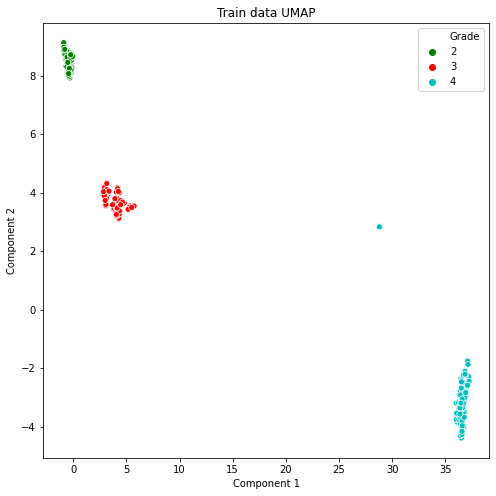

In [218]:
x = train_umap['Component 1']
y = train_umap['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y,  hue = train_umap['Grade'], palette = ['g', 'r', 'c'], hue_order = ['2', '3', '4'])
plt.title("Train data UMAP")
plt.show()

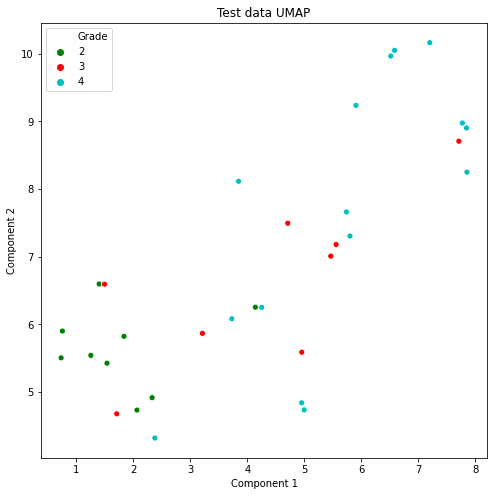

In [150]:
x = test_umap['Component 1']
y = test_umap['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y,  hue = test_umap['Grade'], palette = ['g', 'r', 'c'], hue_order = ['2', '3', '4'])
plt.title("Test data UMAP")
plt.show()

## K-Means on Unsupervised UMAP Components

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(train_umap.iloc[:,:-1])
test_pred = kmeans.predict(test_umap.iloc[:,:-1])

In [204]:
umap_kmeans_test = pd.concat([pd.DataFrame(test_umap), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = train_umap.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
umap_kmeans_test.columns = col_titles

umap_kmeans_test = umap_kmeans_test.replace({'Grade':{'3':'WHO III', '4':'WHO IV', '2':'WHO II'}})
umap_kmeans_test = umap_kmeans_test.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

umap_kmeans_test.head()

,Component 1,Component 2,Grade,K-Means Group
0,4.998853,4.737396,WHO IV,WHO III
1,5.741982,7.662048,WHO IV,WHO IV
2,1.834350,5.824326,WHO II,WHO II
3,1.253050,5.543174,WHO II,WHO II
4,0.730696,5.506590,WHO II,WHO II


In [205]:
umap_kmeans_train = pd.concat([pd.DataFrame(train_umap), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = train_umap.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
umap_kmeans_train.columns = col_titles

umap_kmeans_train = umap_kmeans_train.replace({'Grade':{3:'WHO III', 4:'WHO IV', 2:'WHO II'}})
umap_kmeans_train = umap_kmeans_train.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

umap_kmeans_train.head()

,Component 1,Component 2,Grade,K-Means Group
0,1.853208,6.760010,WHO II,WHO II
1,6.576464,7.091232,WHO IV,WHO IV
2,2.160886,5.699148,WHO II,WHO II
3,3.950415,5.801489,WHO II,WHO II
4,2.561372,5.187484,WHO II,WHO II


### Plot clusters

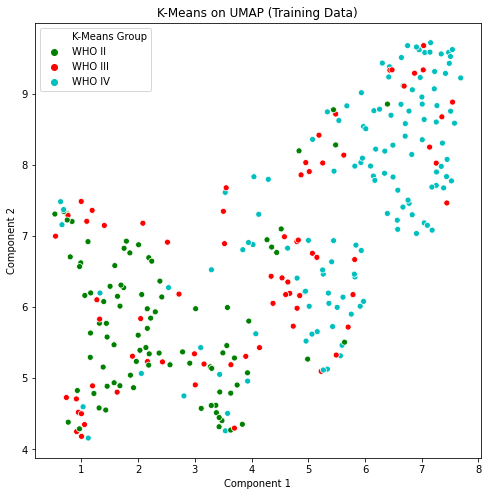

In [206]:
x = umap_kmeans_train['Component 1']
y = umap_kmeans_train['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = umap_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on UMAP (Training Data)")
plt.show()

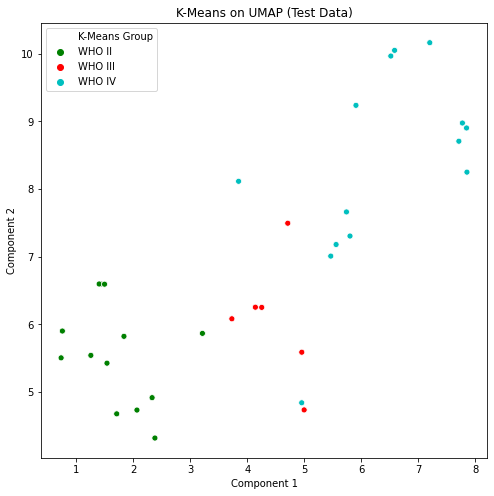

In [207]:
x = umap_kmeans_test['Component 1']
y = umap_kmeans_test['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = umap_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on UMAP (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

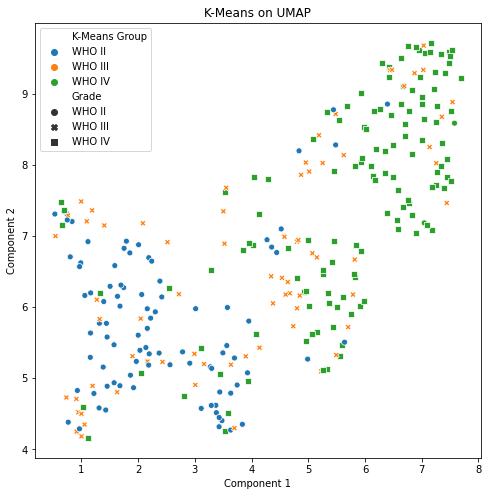

In [208]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = umap_kmeans_train)
plt.title("K-Means on UMAP")
plt.show()

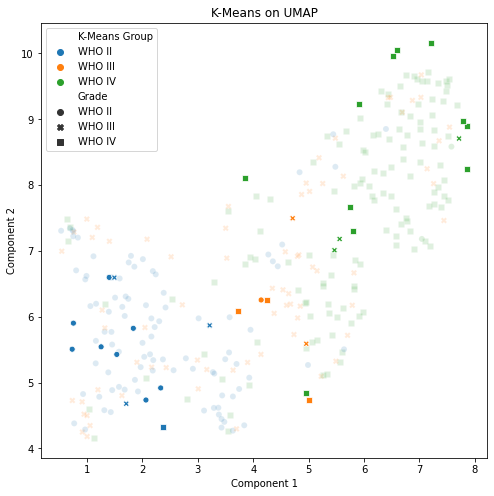

In [209]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = umap_kmeans_train, alpha = .15)
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = umap_kmeans_test, legend = False)
plt.title("K-Means on UMAP")
plt.show()

#### Accuracy Score

In [210]:
get_accuracy(umap_kmeans_train['Grade'], umap_kmeans_train['K-Means Group'])

0.9931506849315068

In [211]:
get_accuracy(umap_kmeans_test['Grade'], umap_kmeans_test['K-Means Group'])

0.6666666666666666

## Fuzzy C-Means On Unsupervised UMAP Components

### Implement

In [160]:
train_umap.iloc[:,0:-1]

,Component 1,Component 2
0,1.853208,6.760010
1,6.576464,7.091232
2,2.160886,5.699148
3,3.950415,5.801489
4,2.561372,5.187484
...,...,...
287,4.955816,8.029866
288,3.635595,5.188318
289,2.219959,5.843037
290,5.064183,5.618593


In [0]:
centers_umap, c_train_umap, init, distance, idk, iterations, fpc_train = cmeans(train_umap.iloc[:,0:-1].T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_umap, init, distance, idk, iterations, fpc_test = cmeans_predict(test_umap.iloc[:,0:-1].T,
                                                                   centers_umap, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [162]:
pd.DataFrame(c_test_umap)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.779085,0.311937,0.002389,0.020475,0.058733,0.492988,0.055902,0.587603,0.061398,0.653057,0.214380,0.952912,0.940871,0.066010,0.113422,0.073496,0.099941,0.443122,0.068728,0.087665,0.799815,0.066415,0.084794,0.691891,0.927098,0.474358,0.129779,0.013048,0.093086,0.095157,0.779330,0.065639,0.105383
1,0.131758,0.054751,0.996979,0.973104,0.920277,0.228570,0.923591,0.065779,0.021748,0.102993,0.735418,0.029539,0.031269,0.911313,0.858876,0.027396,0.045112,0.061342,0.025789,0.029046,0.119591,0.910565,0.031966,0.061656,0.047959,0.470669,0.842063,0.983220,0.881358,0.042278,0.172442,0.912194,0.048187
2,0.089156,0.633312,0.000633,0.006420,0.020990,0.278442,0.020507,0.346618,0.916854,0.243950,0.050202,0.017549,0.027860,0.022677,0.027702,0.899108,0.854947,0.495536,0.905483,0.883290,0.080594,0.023021,0.883239,0.246453,0.024943,0.054972,0.028158,0.003732,0.025557,0.862565,0.048228,0.022167,0.846430


In [163]:
clusters_test_umap = pd.DataFrame(np.argmax(c_test_umap, axis = 0))
umap_cmeans_test = pd.concat([pd.DataFrame(test_umap), pd.DataFrame(clusters_test_umap)], axis = 1)

col_titles[:-2] = test_umap.columns.values[:-1]
col_titles[-2:] = ['Grade', 'C-Means Group']
umap_cmeans_test.columns = col_titles

umap_cmeans_test = umap_cmeans_test.replace({'Grade':{'3':'WHO III', '4':'WHO IV', '2':'WHO II'}})
umap_cmeans_test = umap_cmeans_test.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

umap_cmeans_test.head()

,Component 1,Component 2,Grade,C-Means Group
0,4.998853,4.737396,WHO IV,WHO III
1,5.741982,7.662048,WHO IV,WHO IV
2,1.834350,5.824326,WHO II,WHO II
3,1.253050,5.543174,WHO II,WHO II
4,0.730696,5.506590,WHO II,WHO II


In [164]:
clusters_train_umap = pd.DataFrame(np.argmax(c_train_umap, axis = 0))
umap_cmeans_train = pd.concat([pd.DataFrame(train_umap), pd.DataFrame(clusters_train_umap)], axis = 1)

col_titles[:-2] = train_umap.columns.values[:-1]
col_titles[-2:] = ['Grade', 'C-Means Group']
umap_cmeans_train.columns = col_titles

umap_cmeans_train = umap_cmeans_train.replace({'Grade':{3:'WHO III', 4:'WHO IV', 2:'WHO II'}})
umap_cmeans_train = umap_cmeans_train.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

umap_cmeans_train.head()

,Component 1,Component 2,Grade,C-Means Group
0,1.853208,6.760010,WHO II,WHO II
1,6.576464,7.091232,WHO IV,WHO IV
2,2.160886,5.699148,WHO II,WHO II
3,3.950415,5.801489,WHO II,WHO III
4,2.561372,5.187484,WHO II,WHO II


### Plot clusters

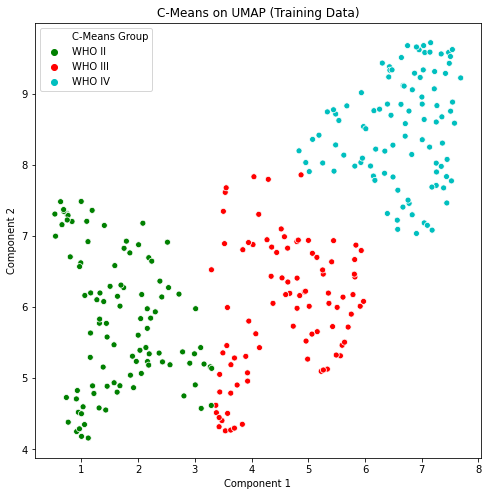

In [165]:
x = umap_cmeans_train['Component 1']
y = umap_cmeans_train['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = umap_cmeans_train['C-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on UMAP (Training Data)")
plt.show()

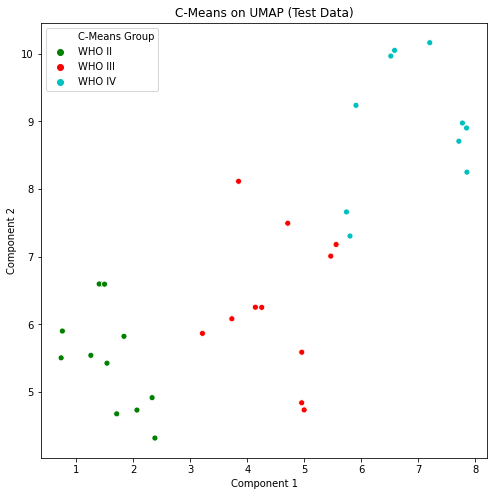

In [166]:
x = umap_cmeans_test['Component 1']
y = umap_cmeans_test['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = umap_cmeans_test['C-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on UMAP (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

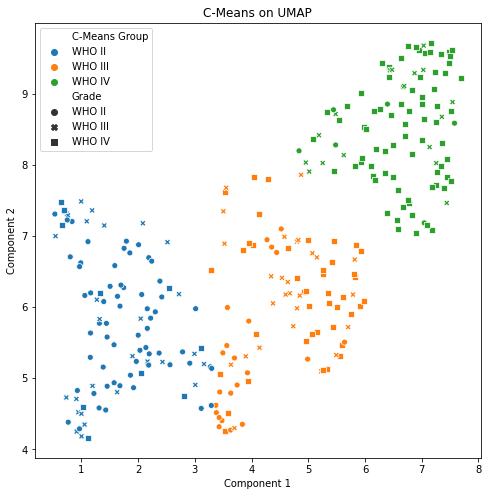

In [167]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = umap_cmeans_train)
plt.title("C-Means on UMAP")
plt.show()

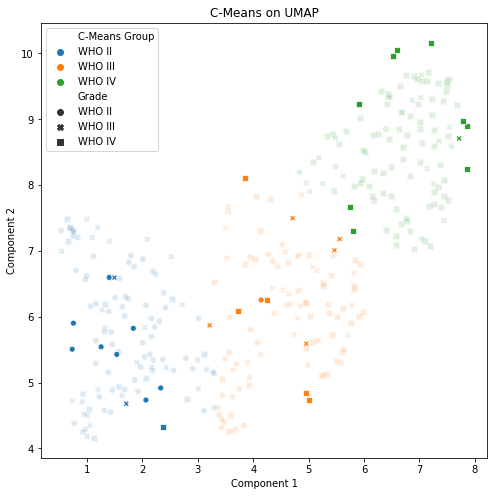

In [168]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = umap_cmeans_train, alpha = .15)
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = umap_cmeans_test, legend = False)
plt.title("C-Means on UMAP")
plt.show()

#### Accuracy Score

In [169]:
get_accuracy(umap_cmeans_train['Grade'], umap_cmeans_train['C-Means Group'])

0.5753424657534246

In [170]:
get_accuracy(umap_cmeans_test['Grade'], umap_cmeans_test['C-Means Group'])

0.696969696969697

# Supervised UMAP

## Implement

In [0]:
temp_lbl = train_lbl.replace({'WHO III':'3', 'WHO IV':'4', 'WHO II':'2'})
temp_lbl.head()
temp_lbl = np.array(temp_lbl)
temp_lbl = temp_lbl.flatten()

In [0]:
i = 6

UMAP = umap.UMAP(n_components = i, n_neighbors = 25, random_state = 50)
sup_train = UMAP.fit_transform(train_data, temp_lbl)

In [173]:
train_sup = pd.concat([pd.DataFrame(sup_train), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Component {x}' for x in range(1, i + 2)]
col_titles[-1:] = ['Grade']
train_sup.columns = col_titles
train_sup = train_sup.replace({'Grade':{'WHO III':'3', 'WHO IV':'4', 'WHO II':'2'}})

train_sup.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade
0,-0.451696,8.320456,2.071356,4.408403,9.137601,0.696062,2
1,36.375832,-3.112167,11.694885,7.312141,4.975802,26.387173,4
2,-0.714322,8.632806,2.278862,4.332727,8.980410,0.837569,2
3,-0.333081,8.313993,1.736220,3.917871,9.136437,0.748806,2
4,-0.507048,8.844954,2.319665,3.926484,8.607699,1.051057,2


In [0]:
### Note: UMAP.embedding_ == UMAP.transform(train_data)

test_sup = UMAP.transform(test_data)

In [175]:
test_sup = pd.concat([pd.DataFrame(test_sup), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Component {x}' for x in range(1, i + 2)]
col_titles[-1:] = ['Grade']
test_sup.columns = col_titles

test_sup = test_sup.replace({'Grade':{'WHO III':'3', 'WHO IV':'4', 'WHO II':'2'}})
test_sup.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade
0,11.308655,3.116712,7.066686,6.570199,7.709240,10.646671,4
1,36.695148,-2.416422,12.189984,6.565116,4.314383,25.766924,4
2,-0.567914,8.460267,2.768974,4.324214,9.010256,0.348506,2
3,-0.989946,8.456622,2.865893,4.097515,8.869952,0.651246,2
4,-0.575487,7.849172,1.863322,4.402063,8.801623,0.577409,2


In [0]:
# test_sup['Grade']

## Plot components

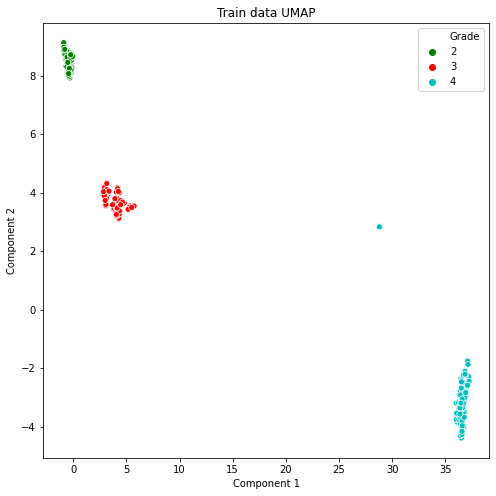

In [219]:
# x = train_sup['Component 1']
# y = train_sup['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot('Component 1', 'Component 2',  hue = 'Grade', palette = ['g', 'r', 'c'], hue_order = ['2', '3', '4'],
               data = train_sup)
plt.title("Train data UMAP")
plt.show()

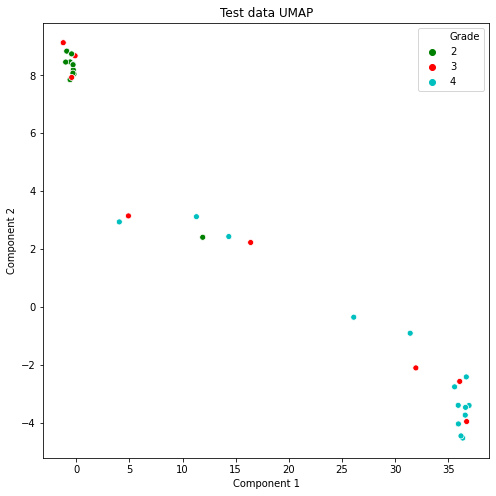

In [178]:
x = test_sup['Component 1']
y = test_sup['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y,  hue = test_sup['Grade'], palette = ['g', 'r', 'c'], hue_order = ['2', '3', '4'])
plt.title("Test data UMAP")
plt.show()

## K-Means on Supervised UMAP Components

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(train_sup.iloc[:,:-1])
test_pred = kmeans.predict(test_sup.iloc[:,:-1])

In [180]:
sup_kmeans_test = pd.concat([pd.DataFrame(test_sup), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = train_sup.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sup_kmeans_test.columns = col_titles

sup_kmeans_test = sup_kmeans_test.replace({'Grade':{'3':'WHO III', '4':'WHO IV', '2':'WHO II'}})
sup_kmeans_test = sup_kmeans_test.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

sup_kmeans_test.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade,K-Means Group
0,11.308655,3.116712,7.066686,6.570199,7.709240,10.646671,WHO IV,WHO III
1,36.695148,-2.416422,12.189984,6.565116,4.314383,25.766924,WHO IV,WHO IV
2,-0.567914,8.460267,2.768974,4.324214,9.010256,0.348506,WHO II,WHO II
3,-0.989946,8.456622,2.865893,4.097515,8.869952,0.651246,WHO II,WHO II
4,-0.575487,7.849172,1.863322,4.402063,8.801623,0.577409,WHO II,WHO II


In [181]:
sup_kmeans_train = pd.concat([pd.DataFrame(train_sup), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = train_sup.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sup_kmeans_train.columns = col_titles

sup_kmeans_train = sup_kmeans_train.replace({'Grade':{'3':'WHO III', '4':'WHO IV', '2':'WHO II'}})
sup_kmeans_train = sup_kmeans_train.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

sup_kmeans_train.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade,K-Means Group
0,-0.451696,8.320456,2.071356,4.408403,9.137601,0.696062,WHO II,WHO II
1,36.375832,-3.112167,11.694885,7.312141,4.975802,26.387173,WHO IV,WHO IV
2,-0.714322,8.632806,2.278862,4.332727,8.980410,0.837569,WHO II,WHO II
3,-0.333081,8.313993,1.736220,3.917871,9.136437,0.748806,WHO II,WHO II
4,-0.507048,8.844954,2.319665,3.926484,8.607699,1.051057,WHO II,WHO II


### Plot clusters

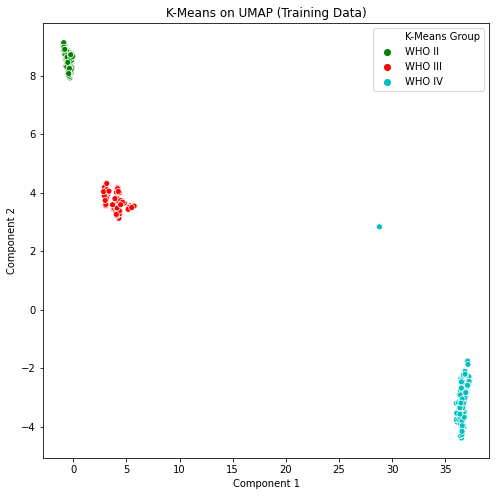

In [182]:
x = sup_kmeans_train['Component 1']
y = sup_kmeans_train['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sup_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on UMAP (Training Data)")
plt.show()

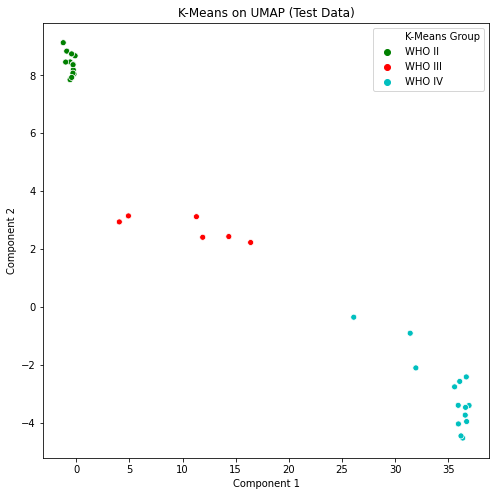

In [183]:
x = sup_kmeans_test['Component 1']
y = sup_kmeans_test['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sup_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on UMAP (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

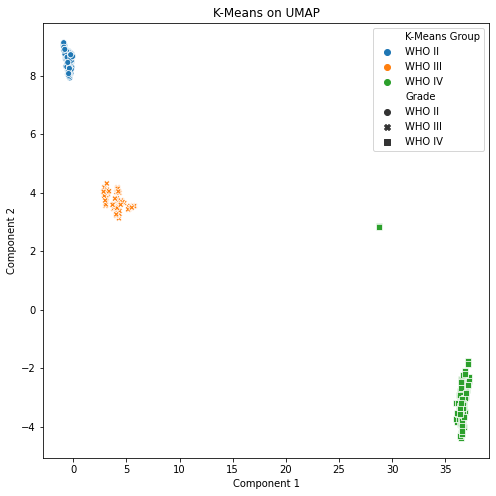

In [184]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sup_kmeans_train)
plt.title("K-Means on UMAP")
plt.show()

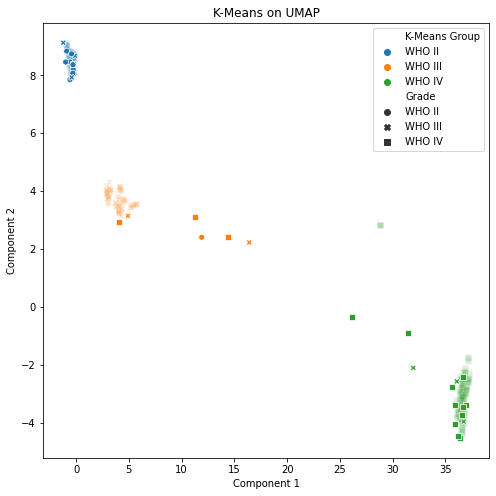

In [185]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sup_kmeans_train, alpha = .15)
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sup_kmeans_test, legend = False)
plt.title("K-Means on UMAP")
plt.show()

#### Accuracy Score

In [186]:
get_accuracy(sup_kmeans_train['Grade'], sup_kmeans_train['K-Means Group'])

0.9931506849315068

In [212]:
get_accuracy(sup_kmeans_test['Grade'], sup_kmeans_test['K-Means Group'])

0.6666666666666666

## Fuzzy C-Means On Supervised UMAP Components

### Implement

In [188]:
train_sup.iloc[:,0:-1]

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6
0,-0.451696,8.320456,2.071356,4.408403,9.137601,0.696062
1,36.375832,-3.112167,11.694885,7.312141,4.975802,26.387173
2,-0.714322,8.632806,2.278862,4.332727,8.980410,0.837569
3,-0.333081,8.313993,1.736220,3.917871,9.136437,0.748806
4,-0.507048,8.844954,2.319665,3.926484,8.607699,1.051057
...,...,...,...,...,...,...
287,4.450670,3.585010,6.696854,6.931089,8.938452,6.998779
288,3.690525,3.582188,7.074272,7.084116,8.633410,6.946305
289,-0.522101,8.448114,2.241682,4.054575,9.081833,0.628478
290,37.096920,-2.587452,11.236512,8.166914,5.065422,26.450403


In [0]:
centers_sup, c_train_sup, init, distance, idk, iterations, fpc_train = cmeans(train_sup.iloc[:,0:-1].T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_sup, init, distance, idk, iterations, fpc_test = cmeans_predict(test_sup.iloc[:,0:-1].T,
                                                                   centers_sup, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [190]:
clusters_test_sup = pd.DataFrame(np.argmax(c_test_sup, axis = 0))
sup_cmeans_test = pd.concat([pd.DataFrame(test_sup), pd.DataFrame(clusters_test_sup)], axis = 1)

col_titles[:-2] = test_sup.columns.values[:-1]
col_titles[-2:] = ['Grade', 'C-Means Group']
sup_cmeans_test.columns = col_titles

sup_cmeans_test = sup_cmeans_test.replace({'Grade':{'3':'WHO III', '4':'WHO IV', '2':'WHO II'}})
sup_cmeans_test = sup_cmeans_test.replace({'C-Means Group': {1:'WHO III', 2:'WHO IV', 0:'WHO II'}})

sup_cmeans_test.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade,C-Means Group
0,11.308655,3.116712,7.066686,6.570199,7.709240,10.646671,WHO IV,WHO III
1,36.695148,-2.416422,12.189984,6.565116,4.314383,25.766924,WHO IV,WHO IV
2,-0.567914,8.460267,2.768974,4.324214,9.010256,0.348506,WHO II,WHO II
3,-0.989946,8.456622,2.865893,4.097515,8.869952,0.651246,WHO II,WHO II
4,-0.575487,7.849172,1.863322,4.402063,8.801623,0.577409,WHO II,WHO II


In [191]:
clusters_train_sup = pd.DataFrame(np.argmax(c_train_sup, axis = 0))
sup_cmeans_train = pd.concat([pd.DataFrame(train_sup), pd.DataFrame(clusters_train_sup)], axis = 1)

col_titles[:-2] = train_sup.columns.values[:-1]
col_titles[-2:] = ['Grade', 'C-Means Group']
sup_cmeans_train.columns = col_titles

sup_cmeans_train = sup_cmeans_train.replace({'Grade':{'3':'WHO III', '4':'WHO IV', '2':'WHO II'}})
sup_cmeans_train = sup_cmeans_train.replace({'C-Means Group': {1:'WHO III', 2:'WHO IV', 0:'WHO II'}})

sup_cmeans_train.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Grade,C-Means Group
0,-0.451696,8.320456,2.071356,4.408403,9.137601,0.696062,WHO II,WHO II
1,36.375832,-3.112167,11.694885,7.312141,4.975802,26.387173,WHO IV,WHO IV
2,-0.714322,8.632806,2.278862,4.332727,8.980410,0.837569,WHO II,WHO II
3,-0.333081,8.313993,1.736220,3.917871,9.136437,0.748806,WHO II,WHO II
4,-0.507048,8.844954,2.319665,3.926484,8.607699,1.051057,WHO II,WHO II


### Plot clusters

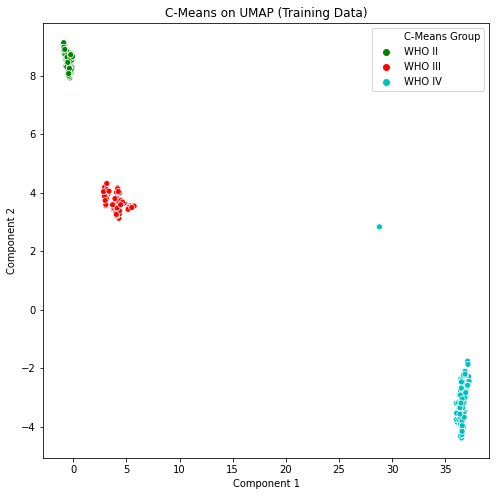

In [192]:
x = sup_cmeans_train['Component 1']
y = sup_cmeans_train['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sup_cmeans_train['C-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on UMAP (Training Data)")
plt.show()

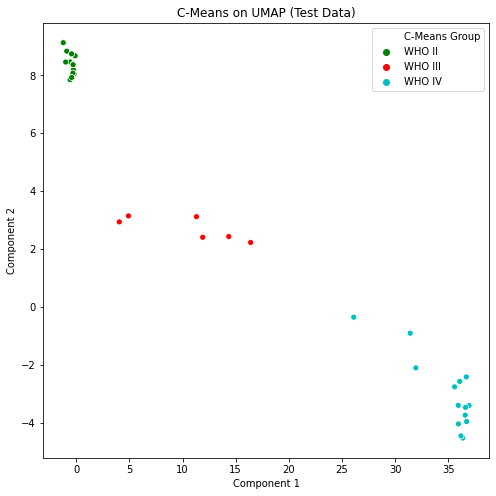

In [193]:
x = sup_cmeans_test['Component 1']
y = sup_cmeans_test['Component 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sup_cmeans_test['C-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on UMAP (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

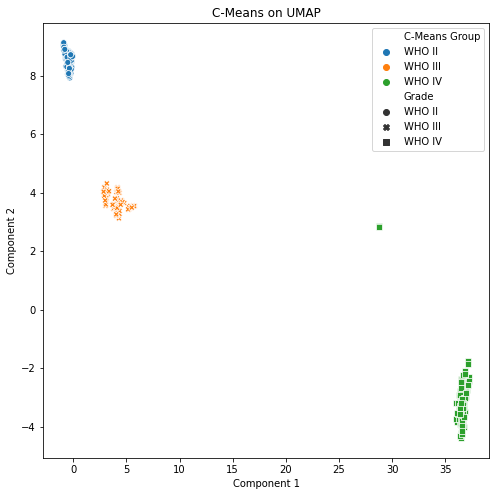

In [194]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sup_cmeans_train)
plt.title("C-Means on UMAP")
plt.show()

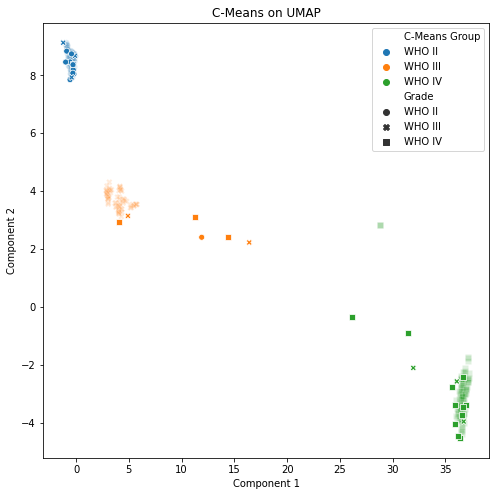

In [195]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sup_cmeans_train, alpha = .15)
sb.scatterplot(x = 'Component 1', y = 'Component 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sup_cmeans_test, legend = False)
plt.title("C-Means on UMAP")
plt.show()

#### Accuracy Score

In [196]:
get_accuracy(sup_cmeans_train['Grade'], sup_cmeans_train['C-Means Group'])

0.9931506849315068

In [197]:
get_accuracy(sup_cmeans_test['Grade'], sup_cmeans_test['C-Means Group'])

0.6666666666666666